In [1]:
%matplotlib notebook

# 6) Reviewing IFU results

In this tutorial, we are going to explore some tools to check the measurements from the [previous tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/5_IFU_Line_Fitting.html#).
You can download this tutorial as a [python script](https://github.com/Vital-Fernandez/lime/blob/master/examples/example6_IFU_results.py) and a [jupyter notebook](https://github.com/Vital-Fernandez/lime/blob/master/examples/notebook6_IFU_results.ipynb). Make sure you have downloaded the MANGA IFU of SHOC579. You can find the link in the [4th tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/4_IFU_Spatial_Masking.html). 


Let’s start by importing the libraries we need:

In [2]:
# This try import is only necessary for the developper to compile the online documentation from this notebook
try:
    import lime
except ImportError:
    import sys
    sys.path.append('../../src')
    import lime
    
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from IPython.display import Image, display
import lime

Let's define the inputs and outputs paths

In [3]:
# State the data location
cfg_file = Path('../sample_data/manga.toml')
cube_file = Path('../sample_data/manga-8626-12704-LOGCUBE.fits.gz')
bands_file_0 = Path('../sample_data/SHOC579_MASK0_bands.txt')
spatial_mask_file = Path('../sample_data/SHOC579_mask.fits')
output_lines_log_file = Path('../sample_data/SHOC579_log.fits')

Now we read the observation and treatment configuration

In [4]:
# Load the configuration file:
obs_cfg = lime.load_cfg(cfg_file)

# Observation properties
z_obj = obs_cfg['SHOC579']['redshift']
norm_flux = obs_cfg['SHOC579']['norm_flux']

With this information, we can load the scientific data and define the ``lime.Cube`` object:

In [5]:
# Open the MANGA cube fits file
with fits.open(cube_file) as hdul:
    wave = hdul['WAVE'].data
    flux_cube = hdul['FLUX'].data * norm_flux
    hdr = hdul['FLUX'].header

We are going to include in the ``lime.Cube`` the World Coordinates System [(WCS)](https://fits.gsfc.nasa.gov/fits_wcs.html) from the observation. This way, the spatial coordinates will be included on the output plots and *.fits* files products:

In [6]:
# WCS from the obsevation header
wcs = WCS(hdr)

# Define a LiMe cube object
shoc579 = lime.Cube(wave, flux_cube, redshift=z_obj, norm_flux=norm_flux, wcs=wcs)

a string value was expected. [astropy.wcs.wcs]


You can check the lines fitted from at a certain spaxel using the interactive ``Cube.check.cube`` function:

<IPython.core.display.Javascript object>


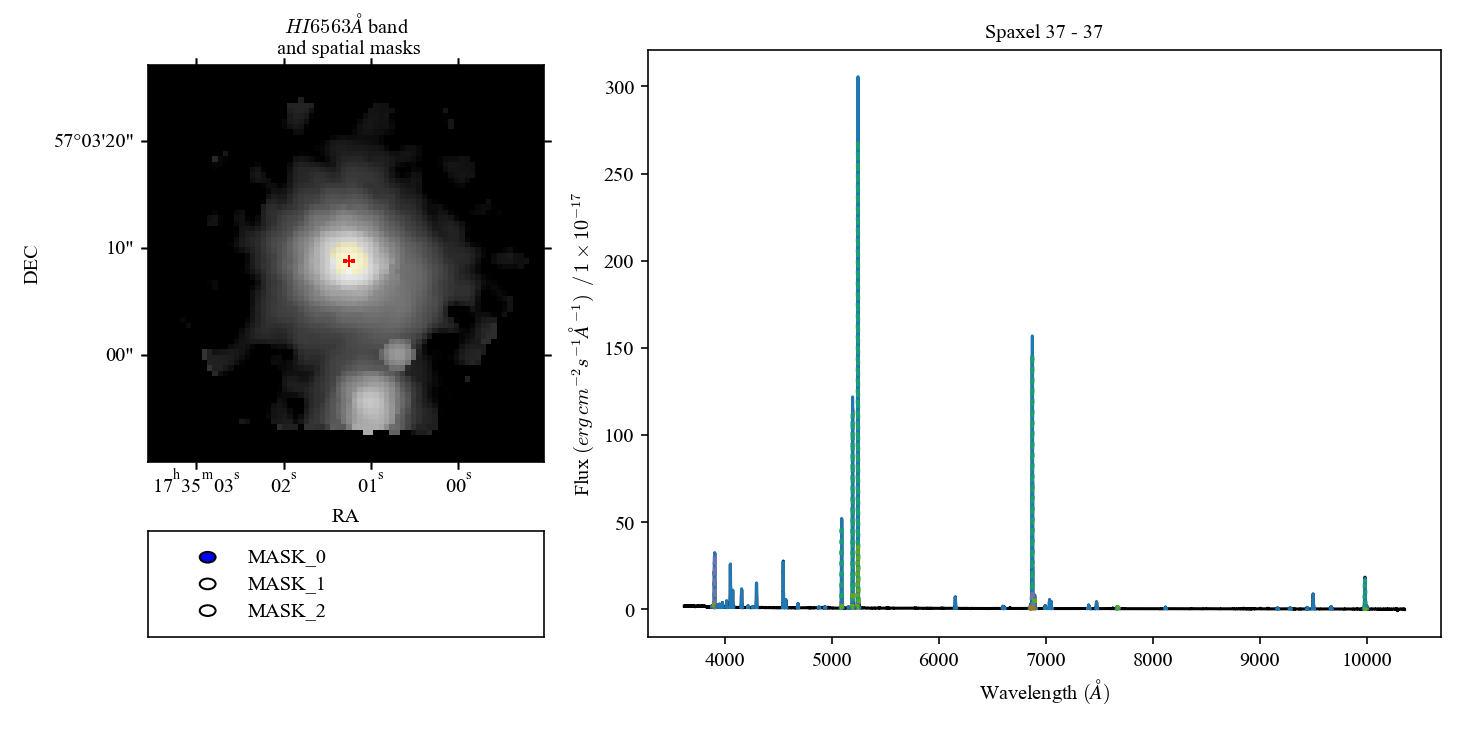

In [7]:
shoc579.check.cube('H1_6563A', lines_log_file=output_lines_log_file, masks_file=spatial_mask_file)

Additinally, you can extract individual ``lime.Spectrum`` from this cube and use the ``Spectrum.plot`` functions:

<IPython.core.display.Javascript object>


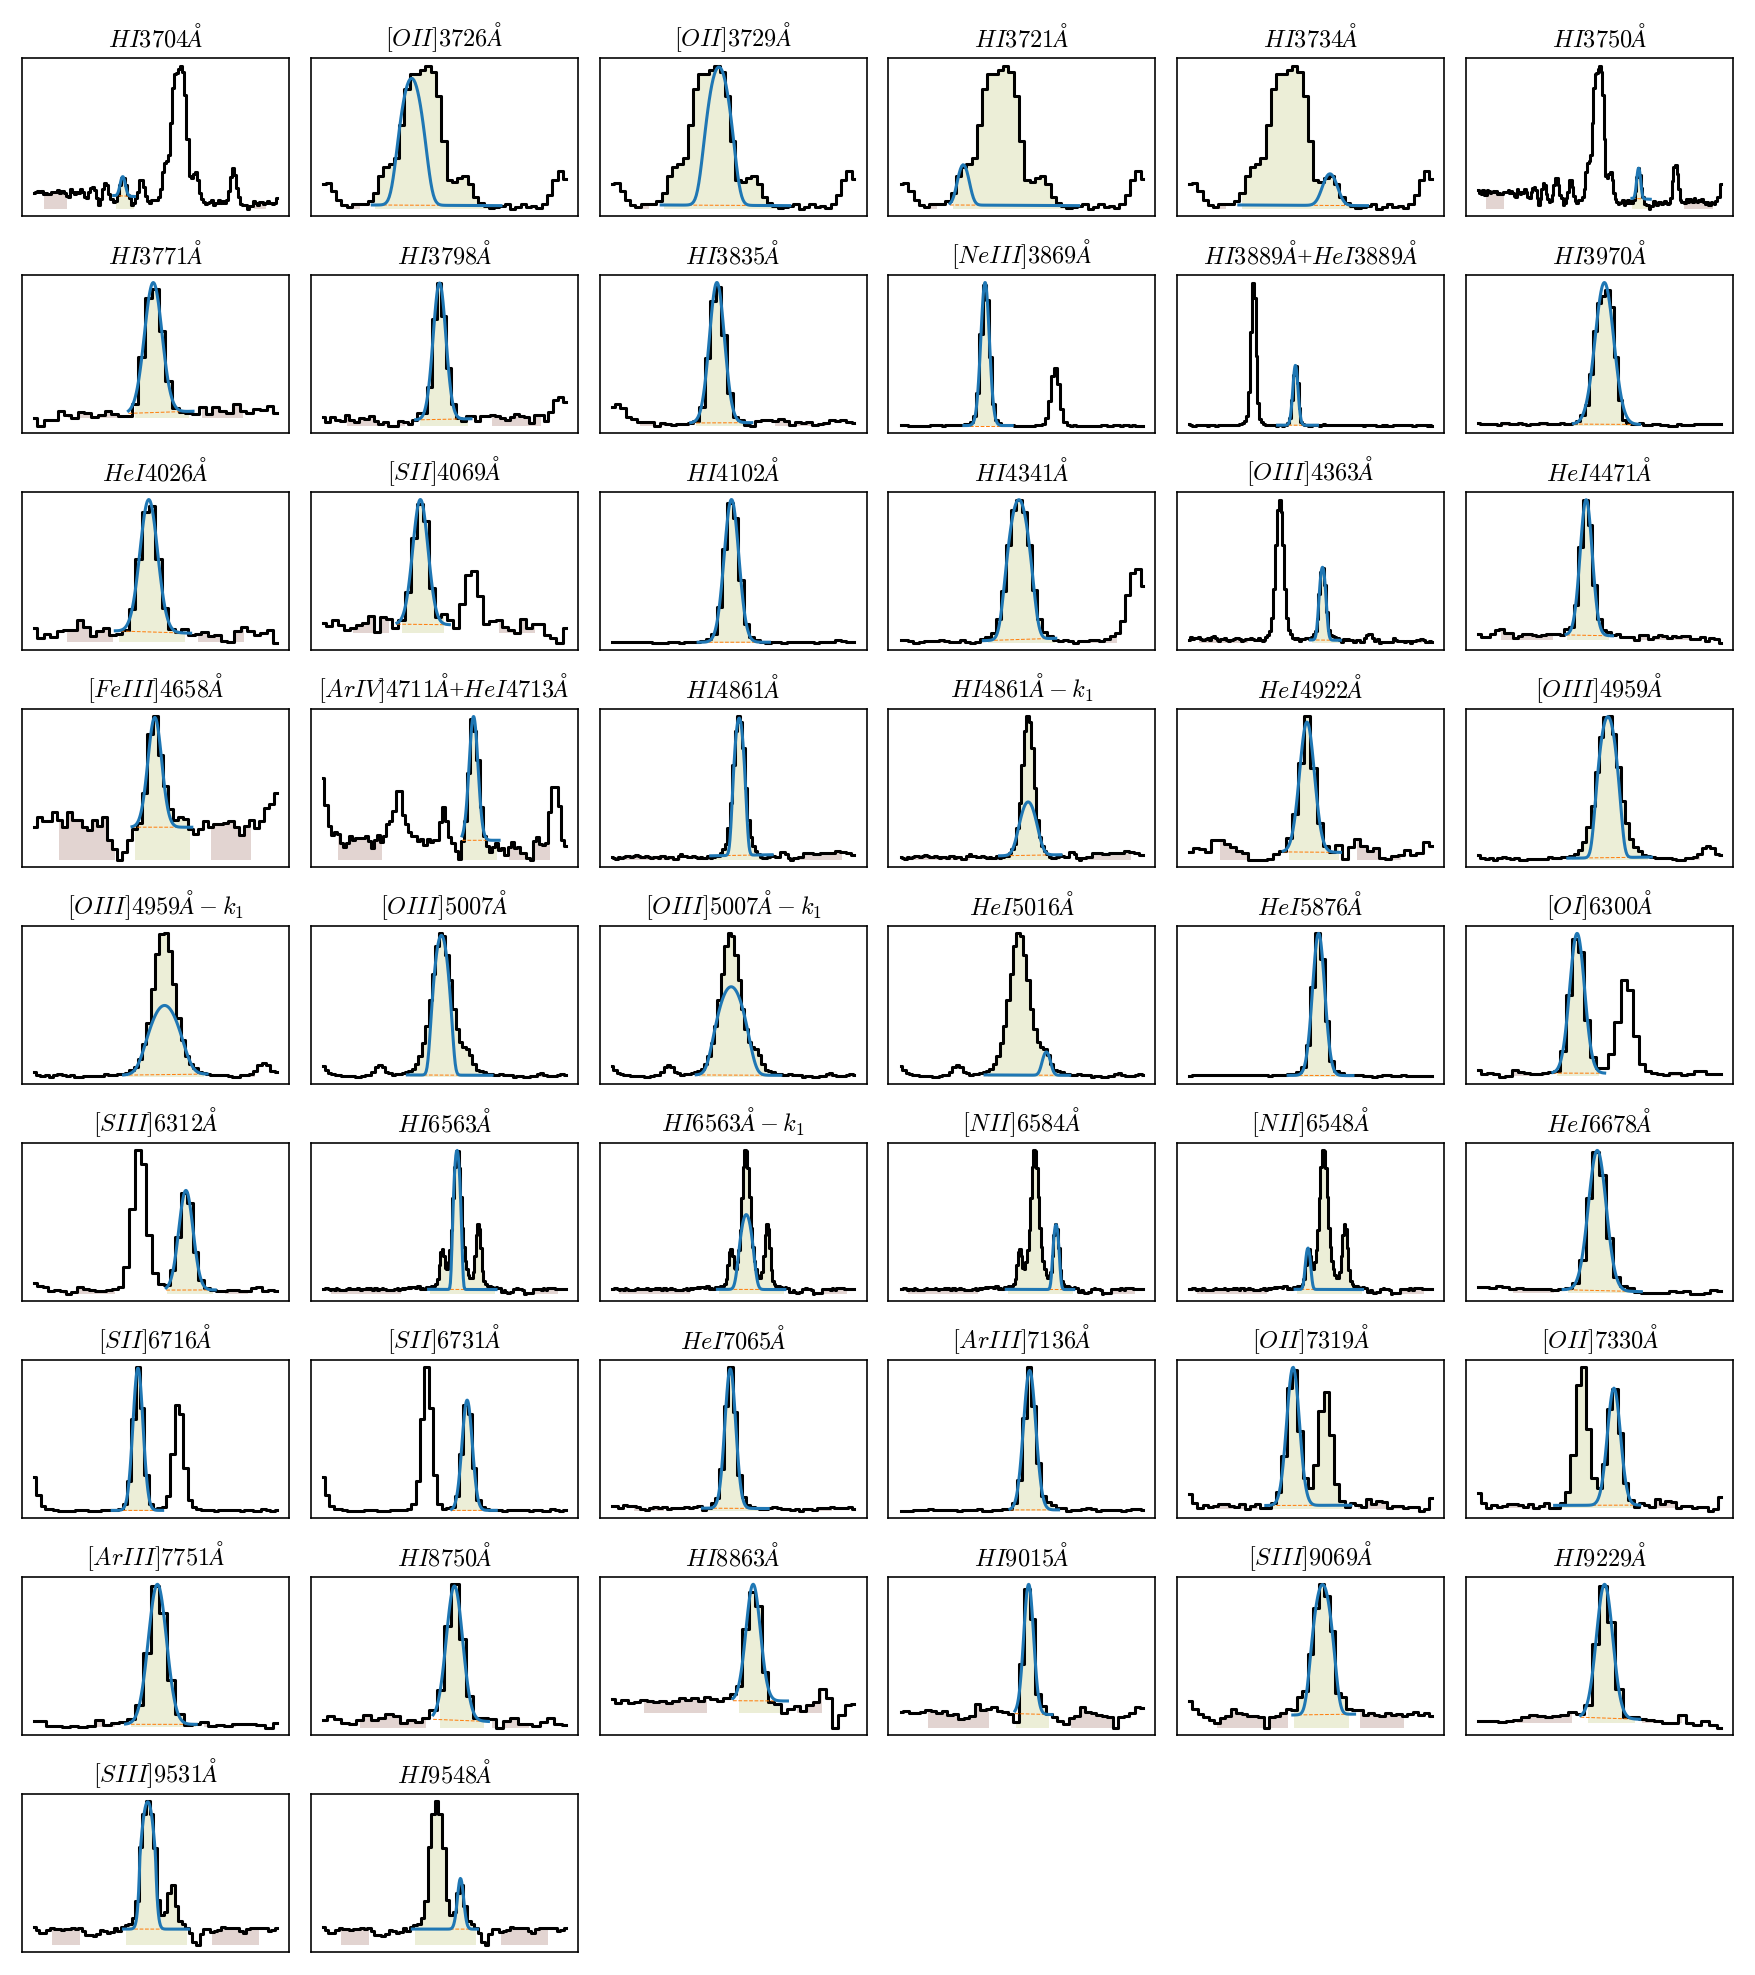

In [10]:
# Check the individual spaxel fitting configuration
spaxel = shoc579.get_spectrum(38, 35)
spaxel.load_log(output_lines_log_file, page='38-35_LINELOG')
spaxel.plot.grid()

You can use $LiMe$ functions to extract and convert indivudal spaxels lines logs from the original *.fits* file:

In [11]:
spaxel_log_df = lime.load_log(output_lines_log_file, page='38-35_LINELOG')
lime.save_log(spaxel_log_df, '../sample_data/38-35_linelog.txt')

## Spatial parameter maps

To take advantage of the IFU spatial data, you will want to explore the evolution of the physical parameters computed from these line measurements. You can use the ``lime.save_parameter_maps`` function:

In [12]:
# Export the measurements log as maps:
param_list = ['intg_flux', 'intg_flux_err', 'gauss_flux', 'gauss_flux_err', 'v_r', 'v_r_err']
lines_list = ['H1_4861A', 'H1_6563A', 'O3_4363A', 'O3_4959A', 'O3_5007A', 'S3_6312A', 'S3_9069A', 'S3_9531A']
lime.save_parameter_maps(output_lines_log_file, '../sample_data/', param_list, lines_list,
                         mask_file=spatial_mask_file, output_file_prefix='SHOC579_', wcs=wcs)

[========= ] 99% of spaxels from file (..\sample_data\SHOC579_log.fits) read (227 total spaxels)


<div class="alert alert-info">

**Please remember:** The inputs and outputs of the ``lime.save_parameter_maps`` can only be *.fits* files.
    
</div>

This function produces different outputs depending on the input parameters:

* The ``parameter_list`` argument establishes which parameters from the input ``output_lines_log_file`` will be exported into a *.fits* file. There will be *.fits* file per item on the ``parameter_list``. These files will be stored on the ``output_folder``  using ``output_files_prefix`` and the item name. The item name must follow the parameter notation of the [logs measurements](https://lime-stable.readthedocs.io/en/latest/documentation/measurements.html).
* The ``line_list`` arguments establishes, which line measurements are exported to the output parameter *.fits* files. Each file will have one page per line.
* The user can specify a binary mask with the ``spatial_mask_file`` argument. By default default it will use all the masks extensions on the input *.fits* unless the user specifies certain masks with the ``ext_mask`` argument.

<div class="alert alert-info">

**Please remember:** It is important to provide an input ``spatial_mask_file`` argument to make sure only spaxels with scientific data are queried on the input ``output_lines_log_file``.
    
</div>

At this point we plot some flux ratio diagnostics from theses maps. Let's define them:

In [13]:
# State line ratios for the plots
lines_ratio = {'H1': ['H1_6563A', 'H1_4861A'],
               'O3': ['O3_5007A', 'O3_4959A'],
               'S3': ['S3_9531A', 'S3_9069A']}

Since some of these lines are blended we are going to use the gaussian fluxes

In [14]:
# State the parameter map file
fits_file = f'../sample_data/SHOC579_gauss_flux.fits'

Let's loop through these ratios and make the plots:

<IPython.core.display.Javascript object>


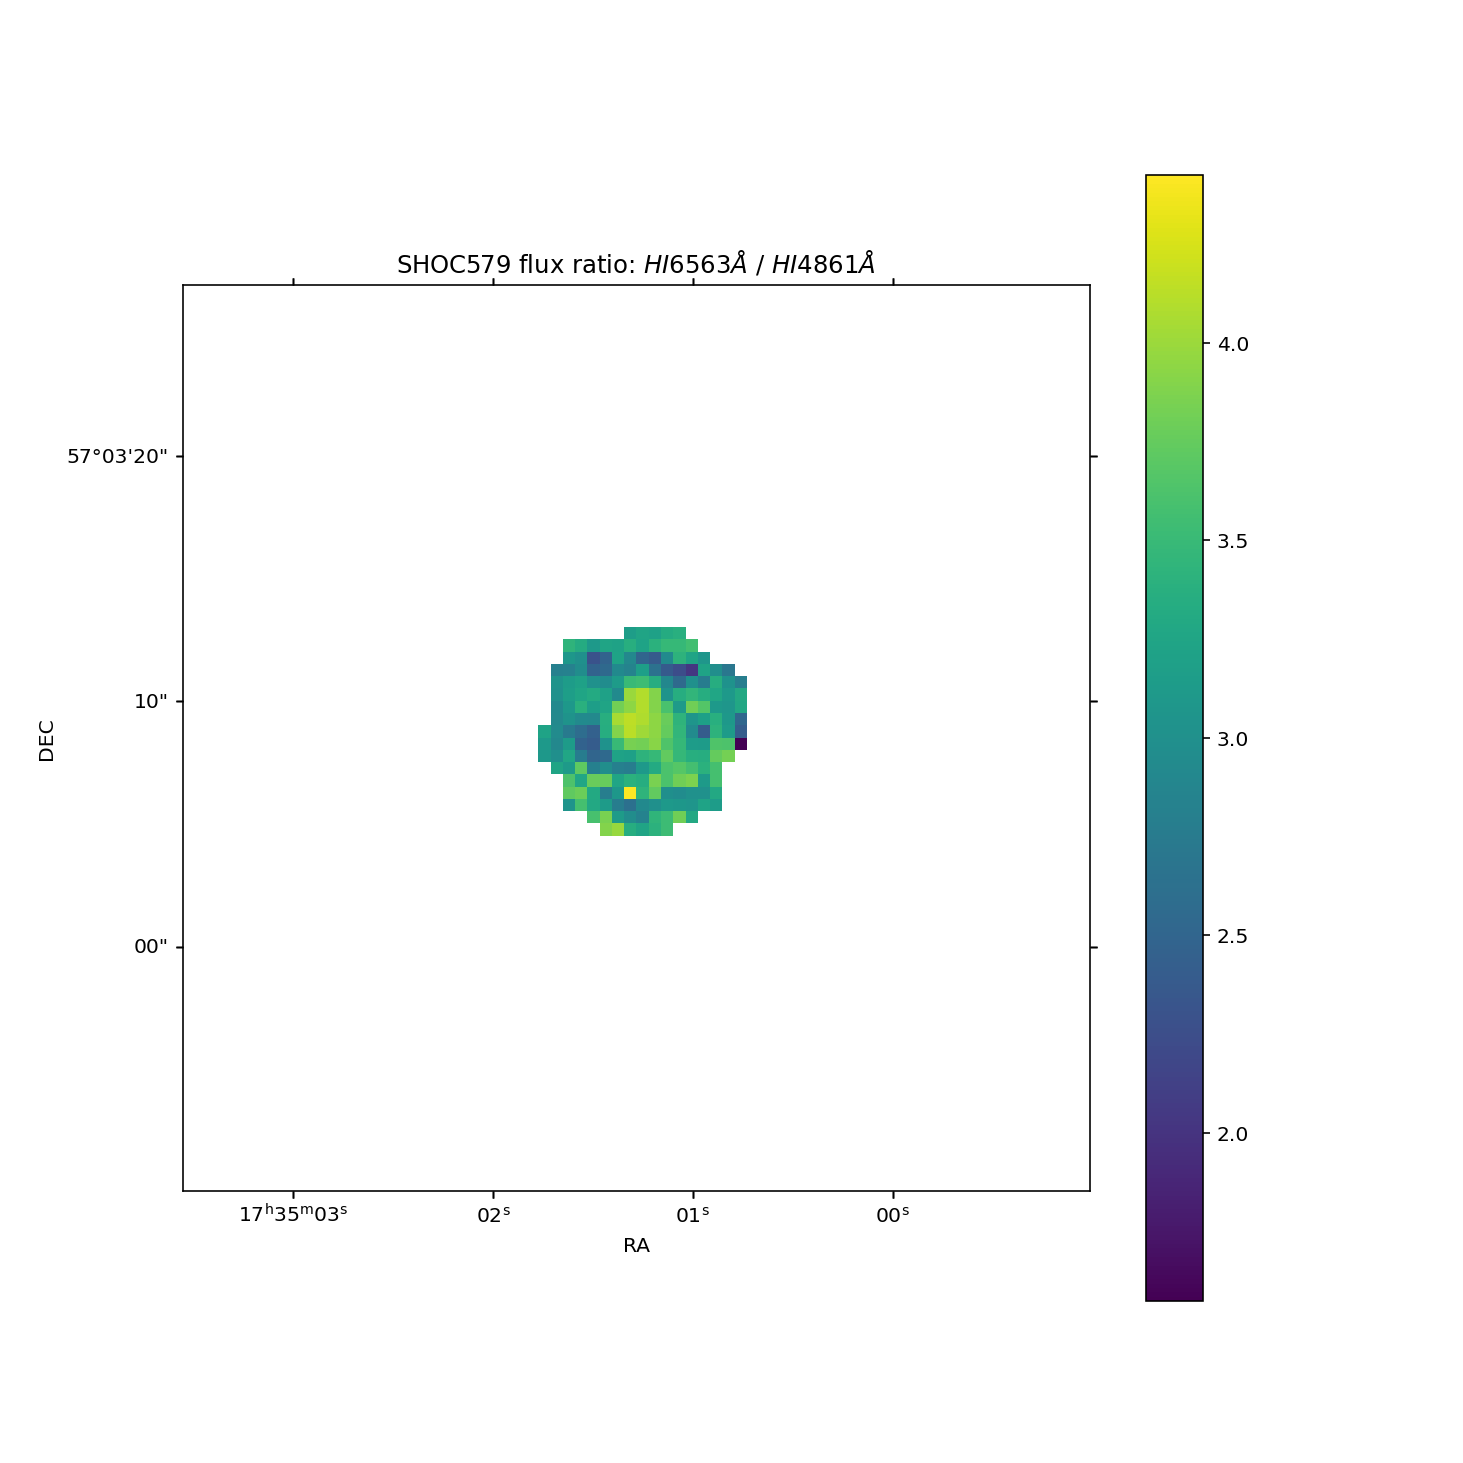

<IPython.core.display.Javascript object>


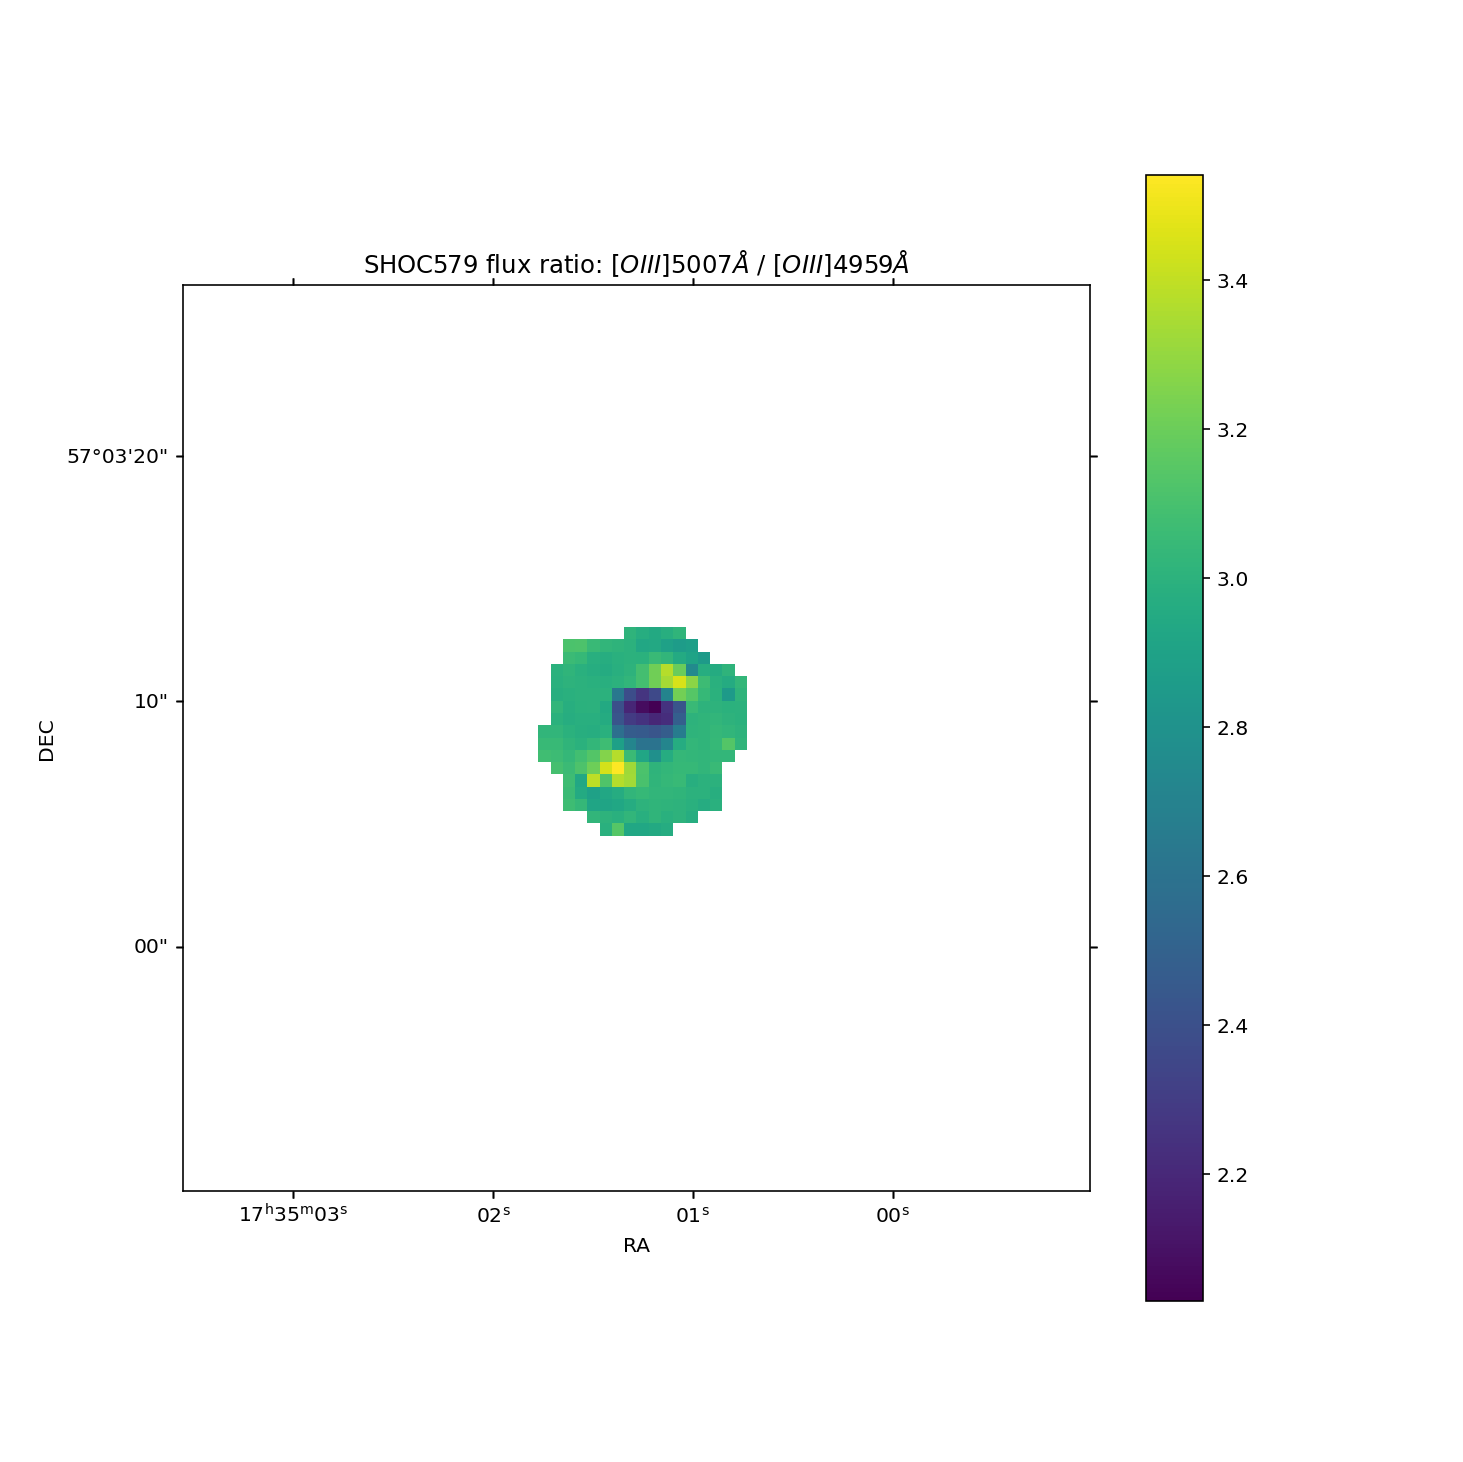

<IPython.core.display.Javascript object>


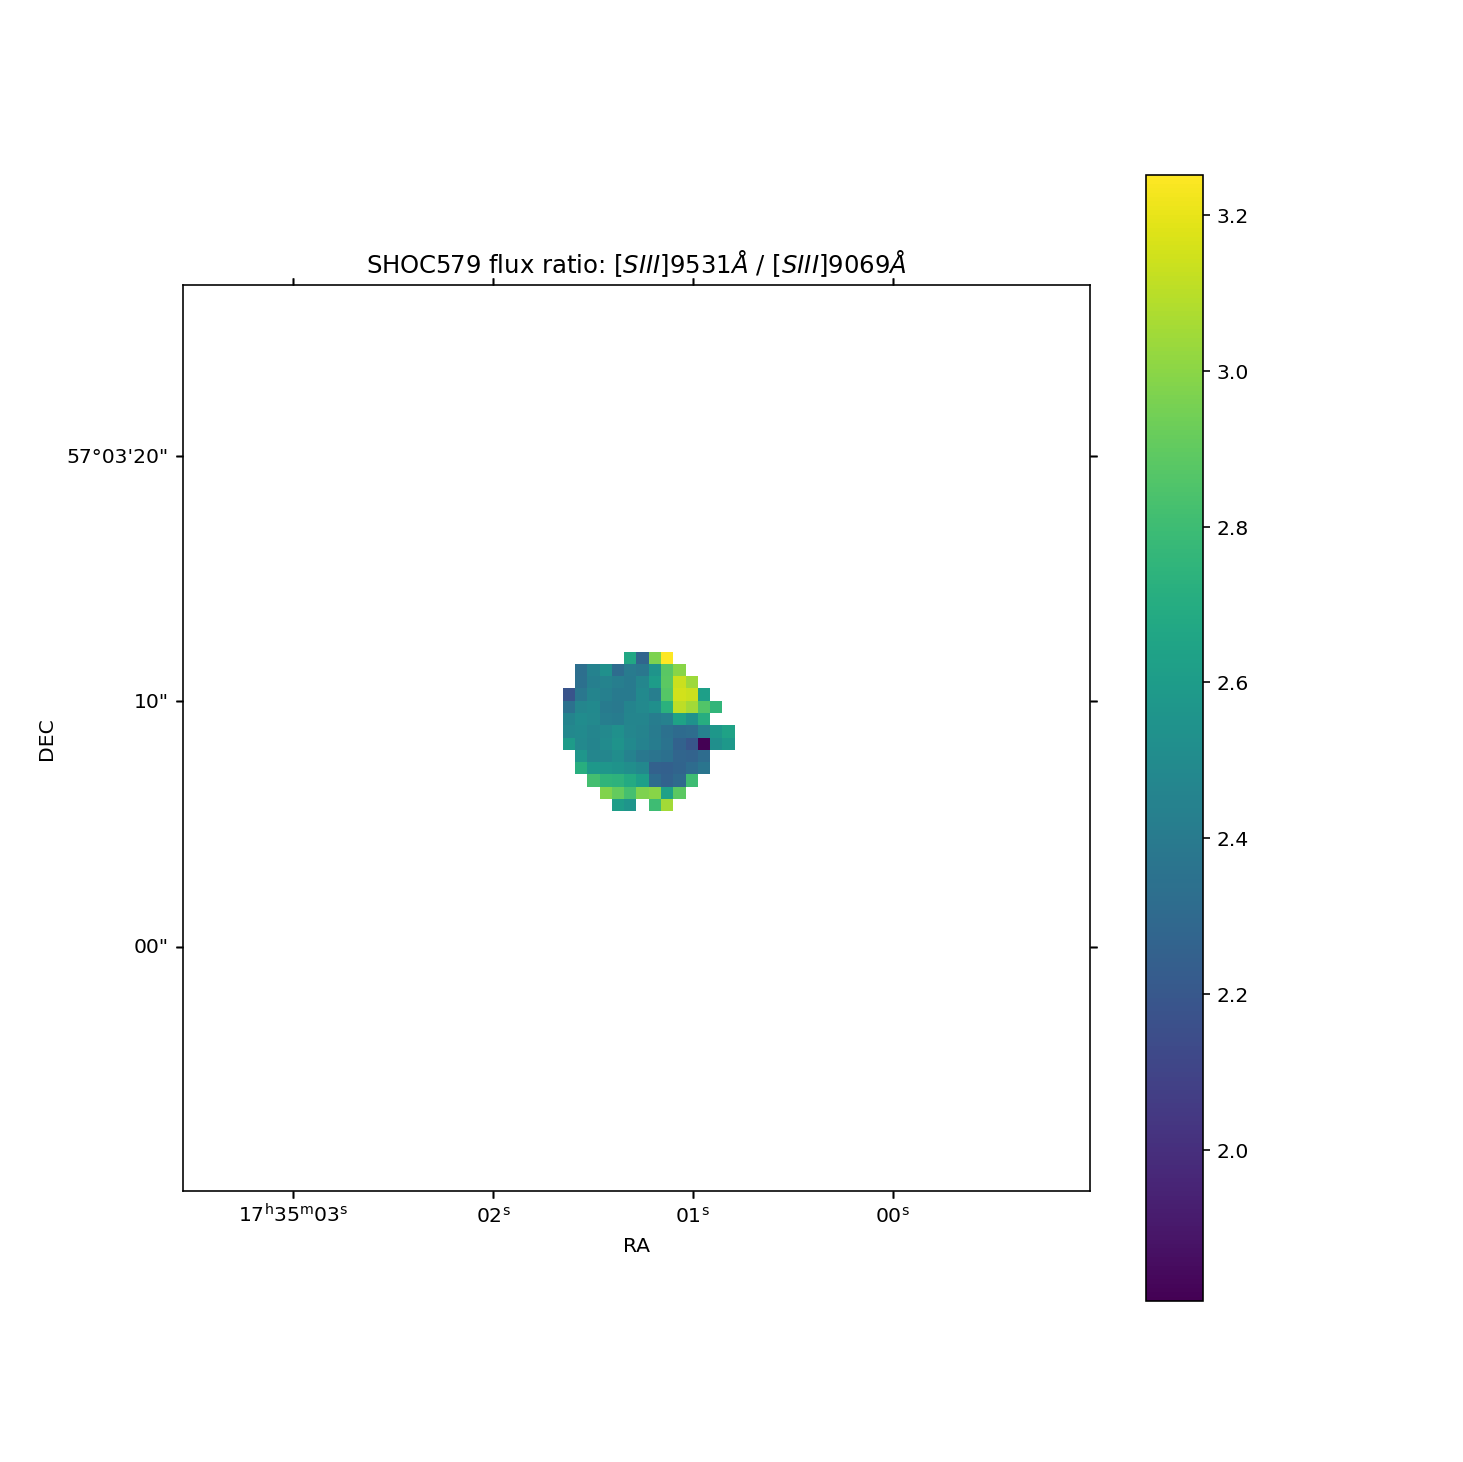

In [15]:
# Loop through the line ratios
for ion, lines in lines_ratio.items():

    # Recover the parameter measurements
    ion_array, wave_array, latex_array = lime.label_decomposition(lines)
    ratio_map = fits.getdata(fits_file, lines[0]) / fits.getdata(fits_file, lines[1])

    # Get the astronomical coordinates from one of the headers of the lines log
    hdr = fits.getheader(fits_file, lines[0])
    wcs_maps = WCS(hdr)

    # Create the plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection=wcs_maps, slices=('x', 'y'))
    im = ax.imshow(ratio_map)
    cbar = fig.colorbar(im, ax=ax)
    ax.update({'title': f'SHOC579 flux ratio: {latex_array[0]} / {latex_array[1]}', 'xlabel': r'RA', 'ylabel': r'DEC'})
    plt.show()

From these plots we can draw the following conclusions:

* The $\frac{H\alpha}{H\beta}$ provides a characterisation of the extinction on the SHOC579. This ratio should be
  above around 2.98, the theoretical emissivity ratio for these lines which is weakly dependant on the physical condition density. However, it seems some pixels have aprubt changes: Could this be because in some spaxels of
  the region 1, we didn't include the wide component of $H\alpha$. Does the profile fitting improve if we include it
  in this region?

* The $\frac{[OIII]5007Å}{[OIII]4959Å}$ ratio should remain constant around 3 independently of the physical
  conditions. Could diversions be caused by the profile fitting? You could check how this map changes if we use the integrated
  flux instead of the gaussian narrow component. Could it be that this line is too intense and therefore the CCD measurement lies outside the linearity region?

* The $\frac{[SIII]9531Å}{[SIII]9069Å}$ ratio should remain constant around 2.47 independently of the physical
  conditions. This seems to be the case for most of the galaxy. In some spaxels, however, the value seems to be lower/higher.
  Could this be explained by the telluric features in the proximity of the lines which could be harder to correct as the ionization radiation becomes weaker?. It may be necesarry to inspect these spaxels individually to confirm the
  if one or both lines are heavily contaminated.

As you may have noticed, at this point we are starting to derive scientific conclusions from the data. In any implementation
of $LiMe$, the user is encouraged to review every step to confirm that the measurements agree with the expected results.
